# Peer-graded Assignment: Эксперименты с моделью

## Загрузка данных

In [157]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split, learning_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, Imputer, StandardScaler
from sklearn.utils.validation import check_is_fitted
from sklearn.svm import LinearSVC
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [8]:
def load_data():
    train_df = pd.read_csv(r'orange_small_churn_train_data.csv', index_col='ID')
    test_df  = pd.read_csv(r'orange_small_churn_test_data.csv', index_col='ID')
    X = train_df.drop(['labels'], axis=1)
    y = train_df['labels'].apply(lambda x: 1 if x==1 else 0)

    X_train, X_hold, \
    y_train, y_hold = train_test_split(X, y,
                                       test_size=0.2,
                                       random_state=9,
                                       shuffle=True,
                                       stratify=y)
    X_test = test_df

    return X_train, X_hold, X_test, y_train, y_hold

## Вспомогательные функции, пайплайн

In [23]:
def get_pipeline(model,
                  missing='mean',
                  encoder='dummy', enc_params=None,
                  selector=None,   sel_params=None):

    # choose encoder

    enc_params = {} if enc_params is None else enc_params
    if encoder == 'dummy':
        encoder = DummyEncoder(**enc_params)
    elif encoder == 'mean_target':
        encoder = MeanTargetEncoder(**enc_params)
    elif encoder == 'frequency':
        encoder = FrequencyEncoder(**enc_params)
    else:
        encoder = NopeTransformer()

    # choose selector

    sel_params = {} if sel_params is None else sel_params
    if selector == 'lasso_svc':
        selector = LassoSelector(**sel_params)
    elif selector == 'correlation':
        selector = CorrelationSelector(**sel_params)
    else:
        selector = NopeTransformer()

    # construct pipeline

    pipeline = Pipeline(steps=[
            # processing
            ('processing', FeatureUnion([

                # numeric features
                ('numeric', Pipeline(steps=[
                    ('selecting',      FunctionTransformer(lambda data: data.iloc[:, :190], validate=False)),
                    ('float_nan_mean', Imputer(strategy=missing)),
                    ('scaling',        StandardScaler())
                ])),

                # categorical features
                ('categorical',   Pipeline(steps=[
                    ('selecting', FunctionTransformer(lambda data: data.iloc[:, 190:], validate=False)),
                    ('encoding',  encoder)
                ]))
            ])),

            # feature selection
            ('feature_selection', selector),

            # model
            ('model', model)
        ])

    return pipeline


class DummyEncoder(BaseEstimator, TransformerMixin):
    '''
    Encodes categorical features as one-hot variables with max_categories restriction
    '''
    def __init__(self, columns=None, max_categories=200):
        self.columns = columns
        self.dummy_columns = None
        self.max_categories = max_categories


    def fit(self, X, y=None, **kwargs):
        self.dummy_columns = None
        return self


    def transform(self, X, y=None, **kwargs):
        if self.max_categories is not None:
            X = X[self.columns] if self.columns is not None else X.copy()
            for col in X.columns:
                top_cats = X[col].value_counts()[:self.max_categories].index.values
                X[col] = X[col].apply(lambda x: x if (x in top_cats or x is None) else 'aggr')

        dummy_df = pd.get_dummies(X, columns=self.columns, sparse=True, dummy_na=True)
        new_cols = dummy_df.columns.values
        if self.dummy_columns is None:
            self.dummy_columns = new_cols
            return dummy_df
        else:
            res_df = pd.DataFrame()
            for col in self.dummy_columns:
                res_df[col] = dummy_df[col] if col in new_cols else np.zeros((len(X),), dtype=int)
        return res_df


class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    '''
    Encodes categorical features by its mean on target variable
    '''
    def __init__(self, columns=None):
        self.columns = columns
        self.dict = None
        return


    def fit(self, X, y=None, **kwargs):
        columns = X.columns if self.columns is None else self.columns
        dict = {}

        X = X.astype(str)

        for col in columns:
            vals = X[col].unique()
            dict[col] = { val: y[X[col] == val].mean() for val in vals }

        self.dict = dict

        return self


    def transform(self, X, y=None, **kwargs):
        check_is_fitted(self, ['dict'])

        X = X.astype(str)
        columns = X.columns if self.columns is None else self.columns

        for col in columns:
            col_dict = self.dict[col]
            X[col] = X[col].apply(lambda x: col_dict.get(x, 0))

        return X


class FrequencyEncoder(BaseEstimator, TransformerMixin):
    '''
    Encodes categorical features by its frequency
    '''
    def __init__(self, columns=None):
        self.columns = columns
        self.dict = None
        return


    def fit(self, X, y=None, **kwargs):
        columns = X.columns if self.columns is None else self.columns
        dict = {}

        X = X.astype(str)
        n = len(X)

        for col in columns:
            vals = X[col].unique()
            dict[col] = { val: (X[col] == val).sum()/n for val in vals }

        self.dict = dict

        return self


    def transform(self, X, y=None, **kwargs):
        check_is_fitted(self, ['dict'])
        X = X.astype(str)
        columns = X.columns if self.columns is None else self.columns

        for col in columns:
            col_dict = self.dict[col]
            X[col] = X[col].apply(lambda x: col_dict.get(x, 0))

        return X


class CorrelationSelector(BaseEstimator, TransformerMixin):
    def __init__(self, n_top=100):
        self.n_top = n_top


    def fit(self, X, y=None):

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # 1. filter out const columns
        vc = X.apply(lambda col: len(col.value_counts()))
        all_cols = vc[vc > 1].index.values

        # 2. correlation feature selection
        num_corrs = X[all_cols].apply(lambda col: correlation(col.values, y), axis=0)
        top_corrs = num_corrs.abs().sort_values(ascending=False)[:self.n_top]

        self.new_cols = sorted(top_corrs.index)

        return self


    def transform(self, X):
        check_is_fitted(self, ['new_cols'])

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        return X.loc[:, self.new_cols]


class LassoSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=None, C=0.1):
        self.threshold = threshold
        self.C = C
        return


    def fit(self, X, y=None):
        model = LinearSVC(C=self.C, penalty='l1', dual=False)
        model.fit(X, y)
        self.selector = SelectFromModel(model, prefit=True, threshold=self.threshold)
        return self


    def transform(self, X):
        check_is_fitted(self, ['selector'])
        return self.selector.transform(X)


class NopeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X


def filter_outliers(X, y, cols, alpha):
    print('filtering outliers...')
    for col in cols:
        var = X[col]
        var_churn = var[y==1]
        var_loyal = var[y==0]

        outliers = len(X)
        condition = None
        col_a = alpha

        while outliers > 200:
            churn_min, churn_max = var_churn.quantile([col_a, 1 - col_a])
            loyal_min, loyal_max = var_loyal.quantile([col_a, 1 - col_a])

            condition = var.isnull() | \
                        ((y==1) & (churn_min <= var) & (var <= churn_max)) | \
                        ((y==0) & (loyal_min <= var) & (var <= loyal_max))

            outliers = len(X) - len(X[condition])
            col_a /= 2

        if condition is not None:
            X = X[condition]
            y = y[condition]
    print('finished: ', len(X))

    return X, y


def undersample(X, y, coeff):

    np.random.seed(9)

    churn = X[y==1].index
    loyal = X[y==0].index.values
    np.random.shuffle(loyal)
    u_loyal = loyal[: int(coeff*len(loyal))]

    u_ids = list(churn) + list(u_loyal)

    return X.ix[u_ids, :], y.ix[u_ids]


def correlation(x, y):
    if set(np.unique(x)) == { 0.0, 1.0 }:
        return matthews_corrcoef(x, y)
    else:
        return point_biserial_corr(x, y)


def point_biserial_corr(x, y):
    y = y[~np.isnan(x)]
    x = x[~np.isnan(x)]
    p = y.mean()
    q = 1 - p
    ex = x.mean()
    sx = x.std(ddof=0)

    px = x[y==1]
    nx = x[y==0]

    mpx = px.mean() if len(px)>0 else 0
    mnx = nx.mean() if len(nx)>0 else 0

    return (mpx - mnx)/sx*math.sqrt(p*q)

## Загрузка и препроцессинг данных (удаление выбросов):

In [27]:
X_train, X_hold, X_test, y_train, y_hold = load_data()
X_train, y_train = filter_outliers(X_train, y_train, X_train.columns[:190], 0.01)

cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=9)

filtering outliers...
finished:  25749


## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

filtering outliers...
finished:  25749


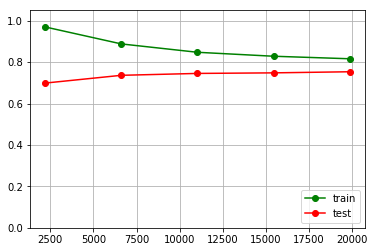

In [10]:
model = XGBClassifier(learning_rate=0.1, n_estimators=120, random_state=9, n_jobs=-1)
pipeline = get_pipeline(model)

train_sizes, train_scores, test_scores = learning_curve(pipeline,
                                                        X_train, y_train,
                                                        train_sizes=np.arange(0.1, 1.0, 0.2),
                                                        cv=cv, scoring='roc_auc')

plt.grid(True)
plt.plot(train_sizes, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
plt.plot(train_sizes, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
plt.ylim((0.0, 1.05))
plt.legend(loc='lower right')
plt.show()

**Выводы:** 
Видно, что с увеличением объема выборки качество на тесте повышается, но остается практически неизменным начинаю уже с 30% объема. Это говорит о том, что выборку можно уменьшить для увеличение скорости обучения и лучшей балансировки классов без потери качества классификации 

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [15]:
ws = [0.5, 1, 10]
for w in ws:
    weights = np.ones_like(y_train)
    weights[y_train==1] = w

    model = XGBClassifier(learning_rate=0.1, n_estimators=120, random_state=9, n_jobs=-1)
    pipeline = get_pipeline(model)

    score = cross_val_score(pipeline,
                            X_train, y_train,
                            scoring='roc_auc', cv=cv,
                            fit_params={ 'model__sample_weight': weights})
    print(w, score.mean())

0.5 0.5
1 0.735232349391
10 0.728518569046


**Выводы:** 
Увеличение веса меньшего класса положительного влияния на результат не оказывает. Оставим веса по умолчанию.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [22]:
u_coeffs = [0.5, 0.2, 0.1, 0.05]
for coeff in u_coeffs:
    X_utrain, y_utrain = undersample(X_train, y_train, coeff)

    model = XGBClassifier(learning_rate=0.1, n_estimators=120, random_state=9, n_jobs=-1)
    pipeline = get_pipeline(model)

    score = cross_val_score(pipeline,
                            X_utrain, y_utrain,
                            scoring='roc_auc', cv=cv)
    print(coeff, score.mean())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:264: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0.5 0.752366656363
0.2 0.742812215815
0.1 0.750040272569
0.05 0.715039394554


**Выводы:** 
Особого влияния на результат undersampling не оказывает. При уменьшении объема большего класса кажество даже может несколько упасть.

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [24]:
missings = ['mean', 'median', 'most_frequent']
for missing in missings:
    model = XGBClassifier(learning_rate=0.1, n_estimators=120, random_state=9, n_jobs=-1)
    pipeline = get_pipeline(model, missing=missing)

    score = cross_val_score(pipeline,
                            X_train, y_train,
                            scoring='roc_auc', cv=cv)
    print(missing, score.mean())

mean 0.754460943002
median 0.748220768529
most_frequent 0.749355845966


**Выводы:** 
Заполнение пропущенных значений средним показывает наиболее хорошие результаты

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [26]:
encoders = ['frequency', 'mean_target', 'dummy']
for encoder in encoders:
    model = XGBClassifier(learning_rate=0.1, n_estimators=100, random_state=9, n_jobs=-1)
    pipeline = get_pipeline(model, encoder=encoder)

    score = cross_val_score(pipeline,
                            X_train, y_train,
                            scoring='roc_auc', cv=cv)
    print(encoder, score.mean())

frequency 0.746875588496
mean_target 0.58789029349
dummy 0.747168555458


**Выводы:** 
Среди всех методов энкодинга категориальных переменных лучше всего себя показал стандартный dummy энкодинг.

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [28]:
selectors = [
    ('correlation', { 'n_top': 30 }),
    ('correlation', { 'n_top': 50 }),
    ('correlation', { 'n_top': 100 }),
    ('lasso_svc',   { 'C': 0.01 }),
    ('lasso_svc',   { 'C': 1 }),
    ('lasso_svc',   { 'C': 10 }),
   ]
for selector, sel_params in selectors:
    model = XGBClassifier(learning_rate=0.1, n_estimators=100, random_state=9, n_jobs=-1)
    pipeline = get_pipeline(model, selector=selector, sel_params=sel_params)
    score = cross_val_score(pipeline,
                            X_train, y_train,
                            scoring='roc_auc', cv=cv)
    print(selector, sel_params, score.mean())

correlation {'n_top': 30} 0.755727490921
correlation {'n_top': 50} 0.753438654871
correlation {'n_top': 100} 0.754566148637
lasso_svc {'C': 0.01} 0.752965929823
lasso_svc {'C': 1} 0.753467819904
lasso_svc {'C': 10} 0.753133505488


**Выводы:**
Не похоже, чтобы стратегия отбора признаков оказывала существенное влияние на результат.
Выберим обычный отбор по коррелляции с максимальным числом признаков равным 30

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [31]:
# для ускорения счета
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=9)

params = {
    'model__n_estimators': [ 100, 200, 300],
    'model__learning_rate': [ 0.01, 0.1, 1 ],
    'model__max_depth': [ 3, 5 ]
    }
model = XGBClassifier(learning_rate=0.1, n_estimators=100, random_state=9, n_jobs=-1)
pipeline = get_pipeline(model, selector='correlation', sel_params={ 'n_top': 30 })
grid = GridSearchCV(pipeline, params, scoring='roc_auc', cv=cv, verbose=10)
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

best_model = grid.best_estimator_

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV] model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100 
[CV]  model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, score=0.7205336688577049, total=  43.9s
[CV] model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.1s remaining:    0.0s


[CV]  model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, score=0.7010964677309904, total=  43.1s
[CV] model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV]  model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, score=0.7253059693822883, total=  43.2s
[CV] model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min remaining:    0.0s


[CV]  model__learning_rate=0.01, model__max_depth=3, model__n_estimators=100, score=0.728902125513229, total=  43.3s
[CV] model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.5min remaining:    0.0s


[CV]  model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200, score=0.7329196122521782, total=  43.5s
[CV] model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.3min remaining:    0.0s


[CV]  model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200, score=0.7075981576601496, total=  43.6s
[CV] model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.2min remaining:    0.0s


[CV]  model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200, score=0.7327614105751591, total=  43.7s
[CV] model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  6.1min remaining:    0.0s


[CV]  model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200, score=0.7394334783093565, total=  43.9s
[CV] model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  6.9min remaining:    0.0s


[CV]  model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300, score=0.7432515255828224, total=  46.5s
[CV] model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  7.8min remaining:    0.0s


[CV]  model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300, score=0.7128693007257547, total=  44.0s
[CV] model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300 
[CV]  model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300, score=0.7413726875085188, total=  45.1s
[CV] model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300 
[CV]  model__learning_rate=0.01, model__max_depth=3, model__n_estimators=300, score=0.7472238440002595, total=  44.1s
[CV] model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100 
[CV]  model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100, score=0.7359724176229002, total=  45.9s
[CV] model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100 
[CV]  model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100, score=0.7022337168018392, total=  45.7s
[CV] model__learning_rate=0.01, model__max_depth=5, model__n_estimators=100 
[CV]  model__learning_rat

[CV]  model__learning_rate=1, model__max_depth=3, model__n_estimators=200, score=0.7025165421021505, total=  43.7s
[CV] model__learning_rate=1, model__max_depth=3, model__n_estimators=200 
[CV]  model__learning_rate=1, model__max_depth=3, model__n_estimators=200, score=0.6831264381891189, total=  43.8s
[CV] model__learning_rate=1, model__max_depth=3, model__n_estimators=200 
[CV]  model__learning_rate=1, model__max_depth=3, model__n_estimators=200, score=0.7122615895174099, total=  43.7s
[CV] model__learning_rate=1, model__max_depth=3, model__n_estimators=200 
[CV]  model__learning_rate=1, model__max_depth=3, model__n_estimators=200, score=0.7145164076559585, total=  43.7s
[CV] model__learning_rate=1, model__max_depth=3, model__n_estimators=300 
[CV]  model__learning_rate=1, model__max_depth=3, model__n_estimators=300, score=0.6995142038529188, total=  44.0s
[CV] model__learning_rate=1, model__max_depth=3, model__n_estimators=300 
[CV]  model__learning_rate=1, model__max_depth=3, model

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 63.7min finished


{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
0.752898632507


**Выводы:**
Изначально параметры были выбраны близкими к оптимальным

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [82]:
cols = best_model.named_steps['feature_selection'].new_cols
num_col_names = X_train.columns.values[:190]
cat_col_names = best_model.named_steps['processing'] \
                      .transformer_list[1][1] \
                      .named_steps['encoding'] \
                      .dummy_columns
col_names = np.concatenate((num_col_names, cat_col_names))[cols]
            
importances = best_model.named_steps['model'].feature_importances_
feature_stats = dict(zip(col_names, importances))

feature_stats = list(sorted(feature_stats.items(), key=lambda kv: kv[1], reverse=True))
best_features = feature_stats[:5]
worst_features = feature_stats[-5:]

print('Лучшие признаки:', best_features)
print('Худшие признаки:', worst_features)

Лучшие признаки: [('Var115', 0.18043685), ('Var102', 0.17378917), ('Var173', 0.11965812), ('Var63', 0.11016145), ('Var12', 0.10731244)]
Худшие признаки: [('Var204_xSqs', 0.0), ('Var206_oZyB', 0.0), ('Var207_wXfldy7', 0.0), ('Var219_tdJW_Pm', 0.0), ('Var222__XSRDbC', 0.0)]


8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [112]:
y_check = best_model.predict_proba(X_train)[:, 1]
y_err = np.abs(y_check - y_train)

1783


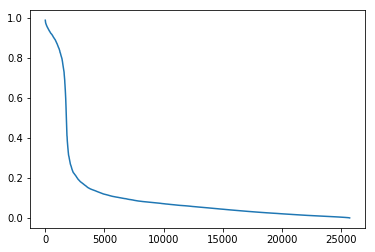

In [113]:
errs = dict(zip(X_train.index.values, y_err))
errs = list(sorted(errs.items(), key=lambda kv: kv[1], reverse=True))

most_errs = list(filter(lambda x: x[1]>0.5, errs))
print(len(most_errs))

x_err, y_err = zip(*errs)

plt.plot(y_err)
plt.show()

Видно, что наибольшая ошибка достигается на некоторых 1783 объектах, на других же она резко меньше.
Посмотрим, чем объекты этих двух групп существенно отличаются.

In [114]:
x_err, y_err = zip(*most_errs)

X_err  = X_train.ix[list(x_err)]
X_norm = X_train.ix[list(set(X_train.index) - set(x_err))]

print(X_train.shape, X_err.shape, X_norm.shape)

(25749, 230) (1783, 230) (23966, 230)


In [121]:
preproc_pipeline = make_pipeline(best_model.named_steps['processing'],
                                 best_model.named_steps['feature_selection'])
X_perr  = preproc_pipeline.transform(X_err)
X_pnorm = preproc_pipeline.transform(X_norm)

print(X_perr.shape, X_pnorm.shape)

(1783, 30) (23966, 30)


In [126]:
mean_diff = (X_perr.mean(axis=0) - X_pnorm.mean(axis=0)).abs().sort_values(ascending=False)
mean_diff

172     0.313594
6       0.271165
101     0.266671
62      0.252948
63      0.249419
11      0.223478
131     0.213975
114     0.201261
1370    0.149825
1665    0.146107
2813    0.120421
399     0.110820
2835    0.107653
1587    0.101546
2799    0.091236
1614    0.090889
2769    0.090147
2323    0.090147
1632    0.079208
1633    0.079208
1590    0.073320
1579    0.062536
379     0.061657
1602    0.061081
1608    0.058943
2359    0.047005
2689    0.047005
798     0.047005
2322    0.030840
304     0.029185
dtype: float64

Видно, что на ряде признаков средние разнятся существенно

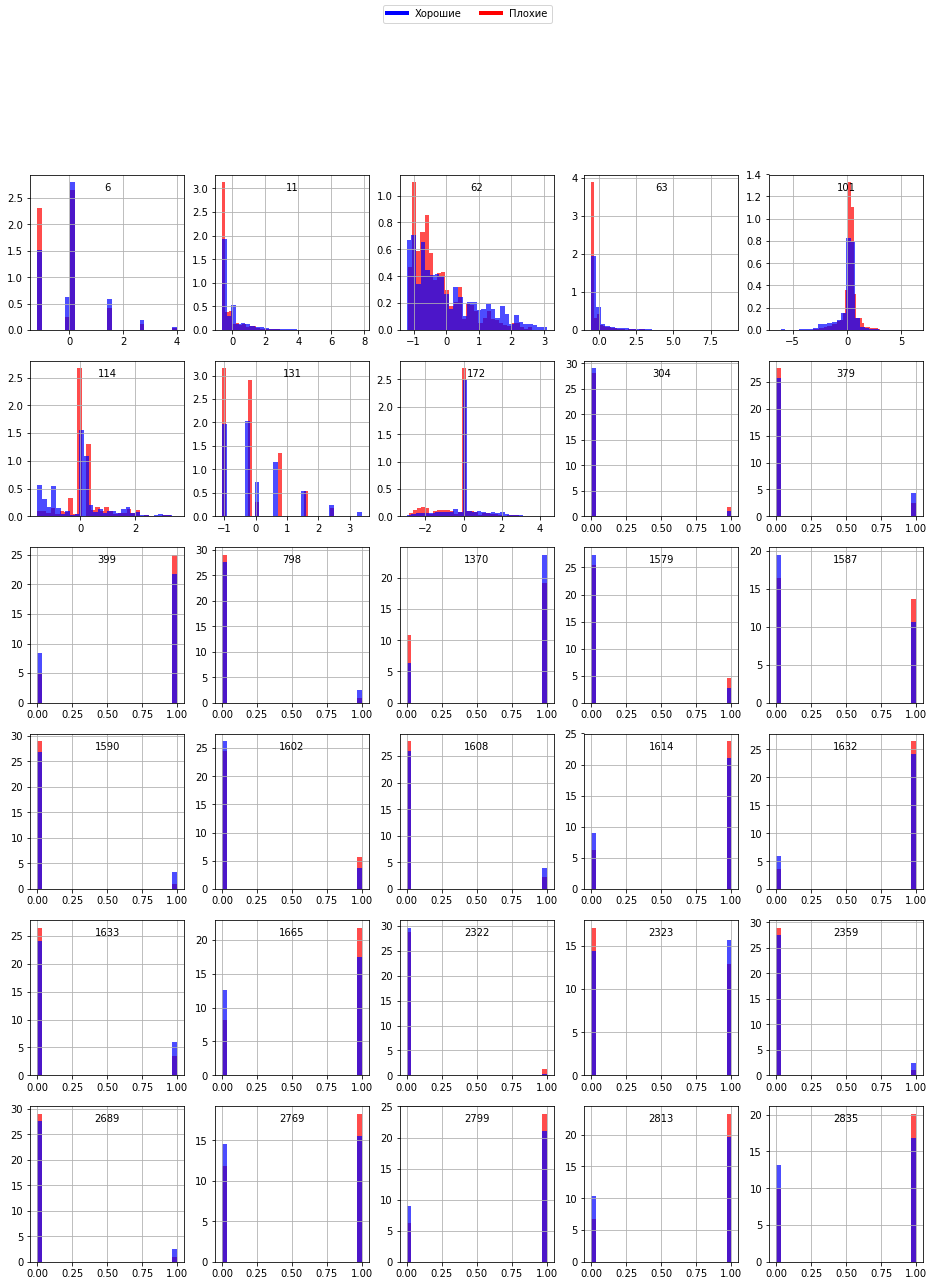

In [146]:
fig, axes = plt.subplots(6, 5, figsize=(16, 20))

legend_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='red', lw=4)]
plt.figlegend(legend_lines, ['Хорошие', 'Плохие'], loc = 'upper center', ncol=6, labelspacing=0. )

for idx, col in enumerate(X_perr.columns):
    i = idx//5
    j = idx%5
    ax = axes[i, j]
    ax.text(.5,.9, col, horizontalalignment='center', transform=ax.transAxes)

    X_perr[col].hist(ax = ax, bins=30, color='red', alpha=0.7, density=True)
    X_pnorm[col].hist(ax = ax, bins=30, color='blue', alpha=0.7, density=True)

plt.show()

In [145]:
init_col_names = list(set([ col.split('_')[0] for col in col_names ]))

err_nans  = X_err[init_col_names].isnull().sum(axis=1)
norm_nans = X_norm[init_col_names].isnull().sum(axis=1)

print(err_nans.mean())
print(norm_nans.mean())

5.293325855300056
5.489985813235417


9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

**Финальная модель:**
Модель с наилучшим качеством получается следующим образом:
- фильтрация выбросов
- 50% undersample-инг
- Заполнение пропущенных значений средним
- dummy-энкодинг категориальных переменных
- отбор признаков по корреляции с целевой переменной с максимальным числом признаков равным 30
- классификатог - XGBClassifier с n_estimators=120 и learning_rate=0.1

In [161]:
# load data
X_train, X_hold, X_test, y_train, y_hold = load_data()
X = pd.concat([X_train, X_hold], axis=0)
y = pd.concat([y_train, y_hold], axis=0)

# filter outliers
X_train, y_train = filter_outliers(X_train, y_train, X_train.columns[:190], 0.01)

# undersample
X_train, y_train = undersample(X_train, y_train, 0.5)

# model & pipeline
model = XGBClassifier(learning_rate=0.1, n_estimators=120, random_state=9, n_jobs=-1)
pipeline = get_pipeline(model)

pipeline.fit(X, y)

y_pred = pipeline.predict_proba(X)[:, 1]
score = roc_auc_score(y, y_pred)

print(score)

filtering outliers...
finished:  25749


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:266: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0.827504393946


10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Модель можно было бы улучшить, посмотрев подробенее на признаки/пары признаков. Мы видели ранее, что некоторые вещественные признаки на самом деле имеют небольшое число разлинчых значений: 2, 3,..., и следовательно, могут быть категориальными. Кроме того, на графиках значений пар признаков видны некоторые неслучайные паттерны: данные располагаются на прямых y = kx и т.п. Возможно, качество улучшилось, если бы мы ввели признаки-отношения и пр.